# Basic Walk-Through: Command-Line Interface

This example shows basic usage of `presto` through its command line interface. We'll run a ligand of TYK2 (a common benchmark system for FEP) with the SMILES `CCC(CC)C(=O)Nc2cc(NC(=O)c1c(Cl)cccc1Cl)ccn2`. The entire workflow can be run in a single line (after activating the environment):
```bash
presto train --parameterisation-settings.smiles "CCC(CC)C(=O)Nc2cc(NC(=O)c1c(Cl)cccc1Cl)ccn2"
```
but we'll go through this in more detail below.

<div style="background-color: #e7f3fe; border-left: 6px solid #2196F3; padding: 10px;">
<strong>Note:</strong> <code>!</code> and <code>%</code> symbols appear before commands in notebook cells to get them to behave as if they were run on the command line. If you're following along, you can ignore them and run the commands directly on the command line.
</div


## Setup

After activating your environment (e.g. with `pixi shell`), navigate to a new directory and use `presto write-default-yaml` to write a default settings file:

In [3]:
! mkdir bespoke-fitting-example-cli
%cd bespoke-fitting-example-cli
! presto write-default-yaml

mkdir: cannot create directory ‘bespoke-fitting-example-cli’: File exists
/home/campus.ncl.ac.uk/nfc78/software/devel/presto/examples/bespoke-fitting-example-cli
2025-12-03 14:52:54.725 | INFO     | presto.utils.rdkit_bespoke_wrapper:__init__:148 - Using RDKitBespokeToolkitWrapper with symmetry-aware SMARTS matching. This will significantly speed up matching for molecules where each type  matches only one set of symmetry-equivalent atoms.
2025-12-03 14:52:54.733 | INFO     | presto._cli:cli_cmd:57 - Writing default YAML settings to workflow_settings.yaml.


Have a look at the contents of the `workflow_settings.yaml` file, which comes pre-populated with all of the default settings for every available option:

In [4]:
! cat workflow_settings.yaml

version: 0.1.2.dev1+g896189d7f.d20251203
output_dir: .
device_type: cuda
n_iterations: 2
memory: false
parameterisation_settings:
  smiles: CHANGEME
  initial_force_field: openff_unconstrained-2.2.1.offxml
  excluded_smirks:
  - '[*:1]-[*:2]#[*:3]-[*:4]'
  - '[*:1]~[*:2]-[*:3]#[*:4]'
  - '[*:1]~[*:2]=[#6,#7,#16,#15;X2:3]=[*:4]'
  linear_harmonics: true
  linear_torsions: false
  msm_settings: null
  expand_torsions: true
training_sampling_settings:
  sampling_protocol: mm_md_metadynamics
  ml_potential: egret-1
  timestep: 1 fs
  temperature: 500 K
  snapshot_interval: 100 fs
  n_conformers: 10
  equilibration_sampling_time_per_conformer: 0.1 ps
  production_sampling_time_per_conformer: 10 ps
  metadynamics_bias_factor: 10.0
  bias_width: 0.3141592653589793
  bias_factor: 10.0
  bias_height: 2.0 kJ * mol**-1
  bias_frequency: 0.5 ps
  bias_save_frequency: 1.0 ps
testing_sampling_settings:
  sampling_protocol: mm_md
  ml_potential: egret-1
  timestep: 1 fs
  temperature: 500 K
  snapsho

Some particularly important settings are:

 * `smiles` under `parameterisation_settings`. You must tell the program what molecule you want to run!
 *  `ml_potential` under `training_sampling_settings` and `testing_sampling_settings`. `egret-1` is the recommended default for neutral molecules, but for charged molecules you should use `aimnet2_wb97m_d3_ens` or another MLP which was trained on charged molecules.
 * `sampling_protocol` under `training_sampling_settings`. Using `mm_md_metadynamics` means that we will run MD with the molecular mechanics force field and use well-tempered metadynamics on rotatable bonds to enhance sampling.

 Change the SMILES and any other settings you'd like in the yaml file.

In [5]:
! sed -i 's/  smiles: CHANGEME/  smiles: "CCC(CC)C(=O)Nc2cc(NC(=O)c1c(Cl)cccc1Cl)ccn2"/' workflow_settings.yaml

Now we're ready to run!

## Execution

Run the fitting with `presto train-from-yaml`. This takes around 4 minutes with a GPU and around an hour using only CPUs.

In [6]:
! presto train-from-yaml workflow_settings.yaml

2025-12-03 15:10:05.085 | INFO     | presto.utils.rdkit_bespoke_wrapper:__init__:148 - Using RDKitBespokeToolkitWrapper with symmetry-aware SMARTS matching. This will significantly speed up matching for molecules where each type  matches only one set of symmetry-equivalent atoms.
2025-12-03 15:10:05.093 | INFO     | presto._cli:cli_cmd:42 - Running presto with settings from workflow_settings.yaml
2025-12-03 15:10:44.088 | INFO     | presto.workflow:get_bespoke_force_field:90 - Generating test data
Running MD for conformer 10:  92%|███████████ | 92/100 [00:00<00:00, 282.63it/s]
/home/campus.ncl.ac.uk/nfc78/software/devel/presto/.pixi/envs/default/lib/python3.13/site-packages/descent/targets/energy.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "coords": torch.tensor(entry["coords"]).flatten().tolist(),
/home/campus.ncl.ac.uk/nfc78/

## Analysis

We now have a bespoke force field: check out `training_iteration_2/bespoke_ff.offxml`. Have a look for the bespoke types at the end of each section:

In [7]:
! cat training_iteration_2/bespoke_ff.offxml

<?xml version="1.0" encoding="utf-8"?>
<SMIRNOFF version="0.3" aromaticity_model="OEAroModel_MDL">
    <Author>The Open Force Field Initiative</Author>
    <Date>2024-09-11</Date>
    <Constraints version="0.3">
        <Constraint smirks="[#1:1]-[#8X2H2+0:2]-[#1]" id="c-tip3p-H-O" distance="0.9572 * angstrom ** 1"></Constraint>
        <Constraint smirks="[#1:1]-[#8X2H2+0]-[#1:2]" id="c-tip3p-H-O-H" distance="1.5139006545247014 * angstrom ** 1"></Constraint>
    </Constraints>
    <Bonds version="0.4" potential="harmonic" fractional_bondorder_method="AM1-Wiberg" fractional_bondorder_interpolation="linear">
        <Bond smirks="[#6X4:1]-[#6X4:2]" id="b1" length="1.533682189836 * angstrom ** 1" k="430.4753865522 * angstrom ** -2 * kilocalorie_per_mole ** 1"></Bond>
        <Bond smirks="[#6X4:1]-[#6X3:2]" id="b2" length="1.509906088505 * angstrom ** 1" k="478.5938624291 * angstrom ** -2 * kilocalorie_per_mole ** 1"></Bond>
        <Bond smirks="[#6X4:1]-[#6X3:2]=[#8X1+0]" id="b3" lengt

We can check out the standard plots to get more information on how well the fitting has gone and how the parameters have changed -- take a look in `plots`:

In [8]:
! ls plots

correlation.png		       loss.png
error_distributions.png        parameter_differences.png
force_error_by_atom_index.png  parameter_values.png


For example, `loss.png` displays how the training loss (computed on the training set) and the test loss (computed on a seperate set of samples generated with the initial molecular mechanics force field) changes during training at each iteration (indexed from 0). Our loss looks well-converged.

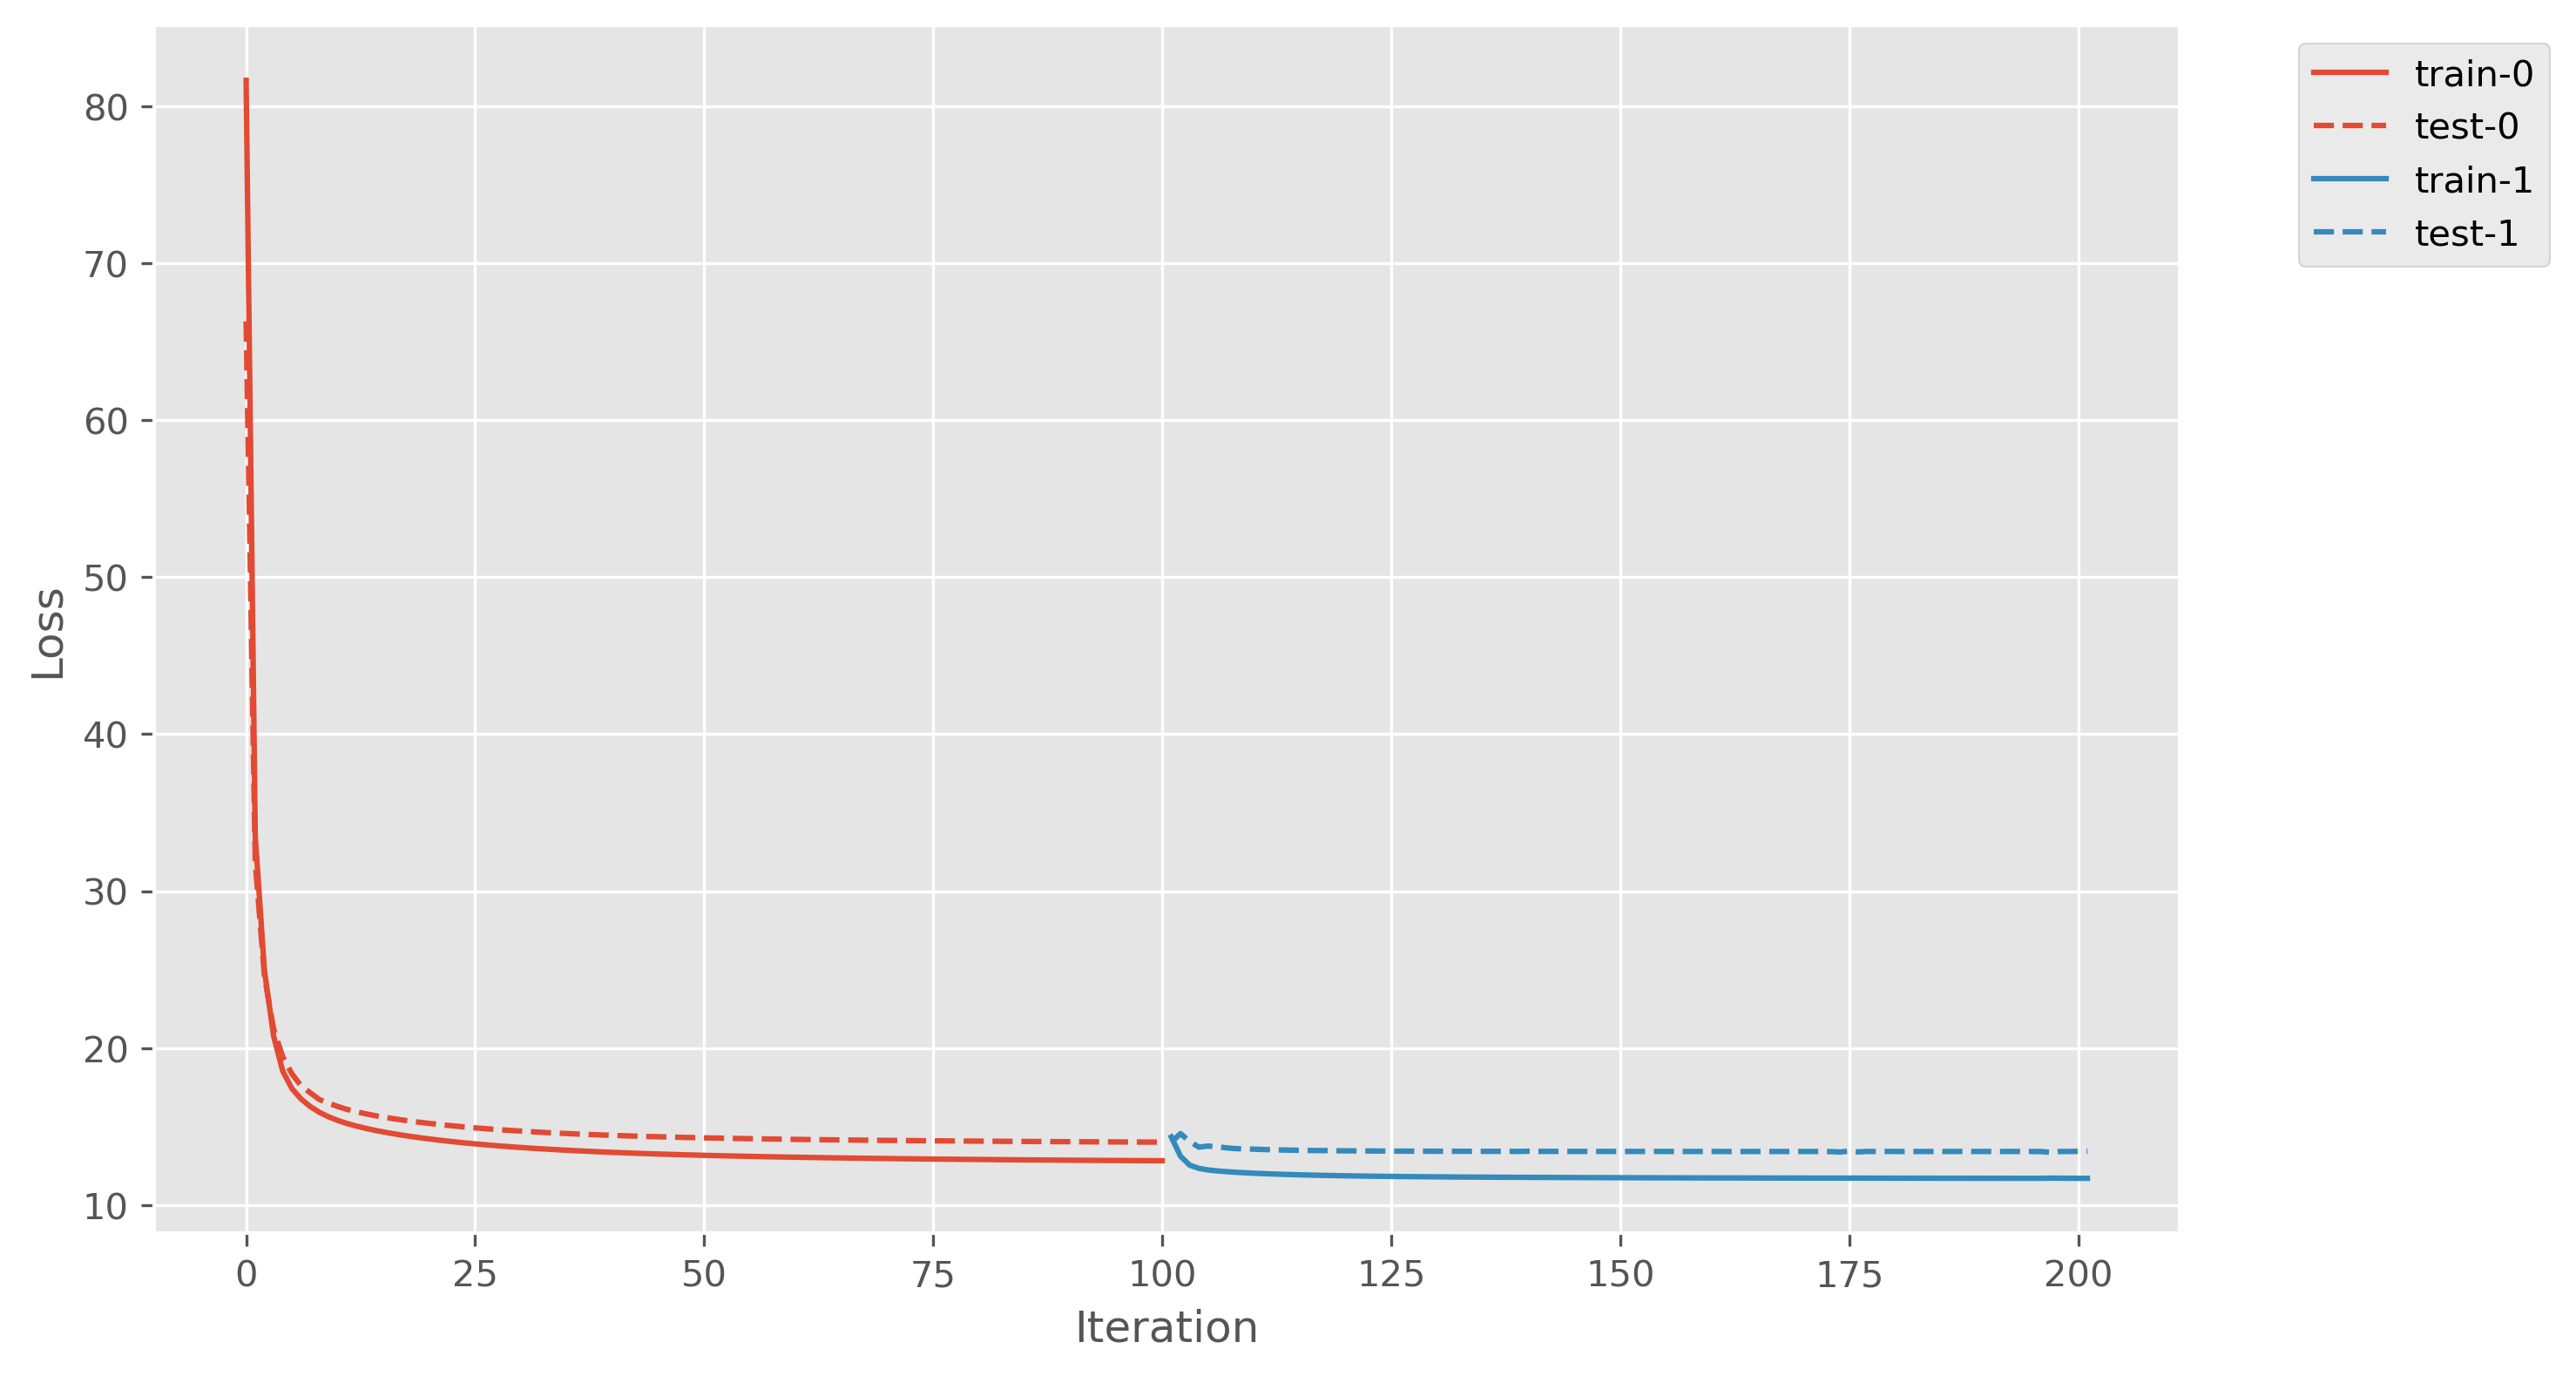

In [10]:
from IPython.display import Image, display

display(Image(filename='plots/loss.png'))

## Using your bespoke force field

Now we have our bespoke force field, we can use it in our intended application. As a quick illustration, we can easily run some vacuum MD with OpenFF's Toolkit and Interchange packages, and OpenMM. First, we can create an `Interchange` object which contains all of the information requied to start molecular dynamics.

In [ ]:
from openff.toolkit import Molecule, ForceField, Topology

force_field = ForceField('training_iteration_2/bespoke_ff.offxml')
molecule = Molecule.from_smiles('CCC(CC)C(=O)Nc2cc(NC(=O)c1c(Cl)cccc1Cl)ccn2')
molecule.generate_conformers(n_conformers=1)

interchange = force_field.create_interchange(molecule.to_topology())

2025-12-03 15:34:25.649 | INFO     | presto.utils.rdkit_bespoke_wrapper:__init__:148 - Using RDKitBespokeToolkitWrapper with symmetry-aware SMARTS matching. This will significantly speed up matching for molecules where each type  matches only one set of symmetry-equivalent atoms.


Now we can run MD with OpenMM:

In [24]:
import openmm
import openmm.unit
from openff.interchange import Interchange
import mdtraj
import nglview


def run_openmm(
    interchange: Interchange,
    reporter_frequency: int = 1000, # Decrease this to save more frames!
    trajectory_name: str = "small_mol_solvated.pdb",
):
    simulation = interchange.to_openmm_simulation(
        integrator=openmm.LangevinMiddleIntegrator(
            300 * openmm.unit.kelvin,
            1 / openmm.unit.picosecond,
            0.002 * openmm.unit.picoseconds,
        ),
    )

    pdb_reporter = openmm.app.PDBReporter(trajectory_name, reporter_frequency)
    simulation.reporters.append(pdb_reporter)

    simulation.context.setVelocitiesToTemperature(300 * openmm.unit.kelvin)
    simulation.runForClockTime(10 * openmm.unit.second)


def visualise_traj(
    topology: Topology, filename: str = "small_mol_solvated.pdb"
) -> nglview.NGLWidget:
    """Visualise a trajectory using nglview."""
    traj = mdtraj.load(
        filename,
        top=mdtraj.Topology.from_openmm(topology.to_openmm()),
    )

    view = nglview.show_mdtraj(traj)
    view.add_representation("licorice", selection="water")

    return view


run_openmm(interchange)
visualise_traj(interchange.topology)

NGLWidget(max_frame=431)

## Cleaning up

To remove all files created by `presto`, you can run `presto clean workflow_settings.yaml`. This does not remove `workflow_settings.yaml`, rather uses it to find the expected files and remove them. This will raise an error and exit if it comes across any files it did not generate in directories it would otherwise delete.

In [25]:
! presto clean workflow_settings.yaml

2025-12-03 15:37:57.848 | INFO     | presto.utils.rdkit_bespoke_wrapper:__init__:148 - Using RDKitBespokeToolkitWrapper with symmetry-aware SMARTS matching. This will significantly speed up matching for molecules where each type  matches only one set of symmetry-equivalent atoms.
2025-12-03 15:37:57.855 | INFO     | presto._cli:cli_cmd:77 - Cleaning output directory with settings from workflow_settings.yaml
